In [1]:
import math
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
import numpy as np
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd 
import numdifftools as nd

C:\Users\Anna\anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
Failed to add gpm alias to meters.


TypeError: find_intersections takes 5 parameters, but 3 units were passed

In [ ]:
ds = xr.open_dataset('/Users/Anna/Desktop/MSMET/AirSea/Project1/wrf_output.nc')

#print(ds.variables)
#print(ds.keys)
#print(ds.shape)

#lat, lon, UC (u current), UV (v current), U10, V10, SST in K, T2 in K, Q2 kg/kg, SLP in hPa
Lat=ds.lat.values
Lon=ds.lon.values

xLen=len(Lon)
yLen=len(Lat)

uCurrent=ds.UC.values
vCurrent=ds.VC.values
currentMag = np.sqrt(uCurrent**2+vCurrent**2) 

uWind=ds.U10.values
vWind=ds.V10.values
windMag = np.sqrt(uWind**2+vWind**2) 

SST=ds.SST.values
SSTC=SST-273.15

airT=ds.T2.values
airTC=airT-273.15

slp=ds.SLP.values
slpPa=slp*100

#QV at 2 M, specific humidity
humid=ds.Q2.values

#np.set_printoptions(threshold=sys.maxsize)
#print(x, y, windMag)

#print(xLen)
#print(yLen)


In [5]:
#mapcrs = ccrs.PlateCarree()
#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
#ax.coastlines()
#filled contours (lon, lat, thing plotted)
#cs = ax.contourf(Lon, Lat, SSTC)
#contnour lines
#ax.contour(Lon, Lat, SSTC, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax.contour(Lon, Lat, SSTC, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
#PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'C')
#gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
#gl.top_labels = False
#gl.ylabels_right = False
#plt.title('SST')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
#plt.show()

In [3]:
from __future__ import print_function
from MFT21 import *
import sys

CONV_CRIT = 0.00005     #convergence critereon (fractional change)  []  
CONVECT = 0.0           #convective parameter  
warn = 0                #warning are given for 1, and hidden for 0    
eqv_neut_prm = 0        #output winds are winds rather than equivalent neutral winds  
z_wanted = 10.0         #height to which winds, potential temp, and humidity are adjusted                                
flux_model = 1         #BVW model=0  

Qnet = 5
sst_prm = 2 #wave age
z0_mom_prm = 0 #like the smith 88 model 
z0_TQ_prm = 1 #0, 1, 4, 5 are all ok 
stable_prm = 1
A_oil = 0.0

#Inputs I set 
dyn_in_prm = 0
dyn_in_val2 = 0.0
air_moist_prm = 0
ref_ht_wind = 10.0
ref_ht_tq = 2.0
sfc_moist_prm = 0
sfc_moist_val = 0.98 #over water 
salinity = 0.349 #global average
ss_prm = 0
ss_val = 28.0 #42.8 #typical of ocean/wind swell
astab = 1

#Outputs 
shf = 0.0
lhf = 0.0
tau = [0.0,0.0]
u_star = [0.0,0.0]
t_star = 0.0
q_star= 0.0
z_over_L = 0.0
wave_age = 0.0
dom_phase_spd = 0.0
hsig = 0.0
ww_stab = 0.0 
zo_m = 0.0001
u_at_z = 0.0
t_at_z = 0.0 
q_at_z = 0.0

#fill new arrays with zeros here 
#fills with float 
shfArr=np.zeros((yLen,xLen))
lhfArr=np.zeros((yLen,xLen))
tauArr=np.zeros((yLen,xLen))
uStarArr=np.zeros((yLen,xLen))
tStarArr=np.zeros((yLen,xLen))
qStarArr=np.zeros((yLen,xLen))
zOverlArr=np.zeros((yLen,xLen))
waveAgeArr=np.zeros((yLen,xLen))
domPhaseSpeedArr=np.zeros((yLen,xLen))
hsigArr=np.zeros((yLen,xLen))
wwStabArr=np.zeros((yLen,xLen))
zomArr=np.zeros((yLen,xLen))
uAtzArr=np.zeros((yLen,xLen))
tAtzArr=np.zeros((yLen,xLen))
qAtzArr=np.zeros((yLen,xLen))

#fill each array with nans 
shfArr[:]=np.nan
lhfArr[:]=np.nan
tauArr[:]=np.nan
uStarArr[:]=np.nan
tStarArr[:]=np.nan
qStarArr[:]=np.nan
zOverlArr[:]=np.nan
waveAgeArr[:]=np.nan
domPhaseSpeedArr[:]=np.nan
hsigArr[:]=np.nan
wwStabArr[:]=np.nan
zomArr[:]=np.nan
uAtzArr[:]=np.nan
tAtzArr[:]=np.nan
qAtzArr[:]=np.nan


#use i & j in future
for x in range(8,xLen-8):
    for y in range(8,yLen-8):
        
        #print('Test1', x, y, windMag[y,x])
        
        #assign other input arrays here
        dyn_in_val = windMag[y,x]
        pressure = slpPa[y,x]
        air_moist_val = humid[y,x]
        t_air=airTC[y,x]
        t_skin=SSTC[y,x]
        
        if np.isnan(t_skin) == False:
        #if dyn_in_val>=0.0 and dyn_in_val<=100.0:
            #continue 
        #if dyn_in_val!=float("nan"):
        #print('Test2')
           
            try:

                count, shf, lhf, tau, u_star, t_star, q_star, z_over_L, wave_age, dom_phase_spd, hsig, ww_stab, zo_m, u_at_z, t_at_z, q_at_z = ht_adj_( dyn_in_prm, 
                        dyn_in_val, dyn_in_val2, CONVECT, CONV_CRIT,
                        pressure, air_moist_prm, air_moist_val, sfc_moist_prm, sfc_moist_val,
                        salinity, ss_prm, ss_val, t_air, sst_prm, t_skin, ref_ht_wind, ref_ht_tq,
                        z_wanted, astab, eqv_neut_prm, Qnet, warn, flux_model, z0_mom_prm, z0_TQ_prm, stable_prm,
                        A_oil, u_star, t_star, q_star, z_over_L, wave_age, dom_phase_spd, hsig, ww_stab, zo_m, u_at_z, t_at_z, q_at_z )

                #shf as output from function above
                #assign other array outputs here

                shfArr[y,x]=shf
                lhfArr[y,x]=lhf
                #take only first part of tau, the second dictionary element is always zero
                tauArr[y,x]=tau[0]
                #dictionary
                uStarArr[y,x]=u_star[0]
                tStarArr[y,x]=t_star
                qStarArr[y,x]=q_star
                zOverlArr[y,x]=z_over_L
                waveAgeArr[y,x]=wave_age
                domPhaseSpeedArr[y,x]=dom_phase_spd
                hsigArr[y,x]=hsig
                wwStabArr[y,x]=ww_stab
                zomArr[y,x]=zo_m
                uAtzArr[y,x]=u_at_z
                tAtzArr[y,x]=t_at_z
                qAtzArr[y,x]=q_at_z
                
                #print(shf)

            except ZeroDivisionError:
                #print whatever type of error it is, and print the values associated with the error 
                print("Problem!")
                print(dyn_in_val)
                print(pressure)
                print(air_moist_val)
                print(t_air)
                print(t_skin)


NameError: name 'yLen' is not defined

In [4]:
#2A
#You will get a stress vector output, but just interpret the first component as a magnitude of the stress (the 2nd component will be zero). 
#For the next step you will need a calculate a stress vector, by multiplying the stress magnitude by a unit vector of the wind shear:
#(tau_x, tau_y) = stress_magnitude * ( u – u_sfc, v – v_sfc) / | ( u – u_sfc, v – v_sfc) |
#For the steps in part 2, (u_sfc, v_sfc) = (0.0, 0.0),
#resulting in a stress vector that is in the same direction as the wind vector. 

#calculate stress vector when current=0
#u_star is m/s

#first try was u_star[0]
#stressI=uStarArr*uWind/abs(uWind)
#stressJ=uStarArr*vWind/abs(vWind)

stressI=tauArr*uWind/abs(uWind)
stressJ=tauArr*vWind/abs(vWind)

stressMag=np.sqrt(stressI**2+stressJ**2) 
#print(stressI.shape)
#print(stressJ.shape)
#print(stressMag.shape)


NameError: name 'tauArr' is not defined

In [13]:
#2B - metPy Version
#Calculate the curl of the stress (from 2A) and plot
#You can calculate it as a finite difference 
#(realizing that the change in longitude is a function of latitude) or by using the circulation method. 
#Turn in the plot of the curl of the stress. 
        
#Vorticity=curl
dxdy=mpcalc.lat_lon_grid_deltas(longitude=Lon, latitude=Lat, x_dim=- 1, y_dim=- 2, geod=None)
#print(dxdy.shape)
#print(dxdy)

#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
curlNoCurrent=mpcalc.vorticity(u=stressI*units('m/s'), v=stressJ*units('m/s'), dx=dxdy[0], dy=dxdy[1])
#print(curlNoCurrent)



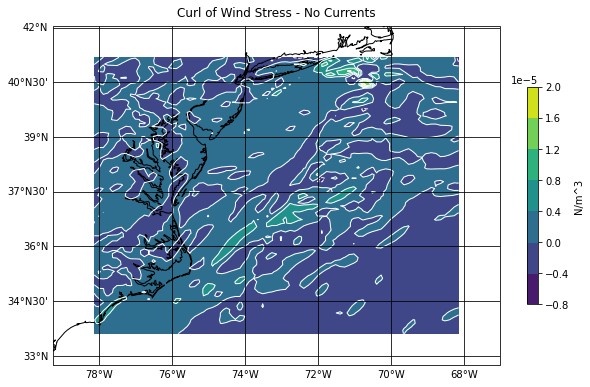

In [14]:
#2B Plot - metPy version

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, curlNoCurrent)
#contnour lines
ax.contour(Lon, Lat, curlNoCurrent, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Curl of Wind Stress - No Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


In [10]:
#2B PLOT - hard code version

#get dy & dx
#deg2Meter=111100
#new_dx=np.zeros((98,98))
#new_dy=np.zeros((98,98))
#for y in range(len(Lat)-1):
#    new_dy[:,y]=(Lat[y+1]-Lat[y])*deg2Meter
#for y in range(len(Lat)-1):
#    latAdjust=np.cos(np.pi*Lat[y]/180)
#    for x in range(len(Lon)-1):
#        new_dx[y,x]=(Lon[x+1]-Lon[x])*deg2Meter*latAdjust

#print(new_dx.shape)
#print(new_dy.shape)

#dudy=np.zeros((97,97))
#dvdx=np.zeros((97,97))

#get vorticity/curl 
#for y in range(1,len(Lat)-2):
#    for x in range(1,len(Lon)-2):
        #Winds
        #dudyN=(uWind[y-1,x]-uWind[y,x])/((Lat[y-1]-Lat[y])*deg2Meter)
        #dudyS=(uWind[y,x])-uWind[y+1,x]/((Lat[y]-Lat[y+1])*deg2Meter)
        #dvdxE=(vWind[y,x+1]-vWind[y,x])/((Lon[x+1]-Lon[x])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
        #dvdxW=(vWind[y,x-1]-vWind[y,x])/((Lon[x]-Lon[x-1])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
        
        #Wind Stress
#        dudyN=(stressI[y-1,x]-stressI[y,x])/((Lat[y-1]-Lat[y])*deg2Meter)
#        dudyS=(stressI[y,x])-stressI[y+1,x]/((Lat[y]-Lat[y+1])*deg2Meter)
#        dvdxE=(stressJ[y,x+1]-stressJ[y,x])/((Lon[x+1]-Lon[x])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
#        dvdxW=(stressJ[y,x-1]-stressJ[y,x])/((Lon[x]-Lon[x-1])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
        
        
#        dudy[y,x]=(dudyN+dudyS)/2
#        dvdx[y,x]=(dvdxE+dvdxW)/2

#curlNoC=dvdx-dudy

#print(curl.shape)
#print(curl)

In [11]:
#2B PLOT - hard code version

#mapcrs = ccrs.PlateCarree()
#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
#ax.coastlines()
#filled contours (lon, lat, thing plotted)
#cs = ax.contourf(Lon[1:98], Lat[1:98], curlNoC, transform=mapcrs)
#contnour lines
#ax.contour(Lon[1:98], Lat[1:98], curlNoC, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
#PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, label = '1/s')
#gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
#gl.top_labels = False
#gl.ylabels_right = False
#plt.title('Curl of Wind Stress - No Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
#plt.show()


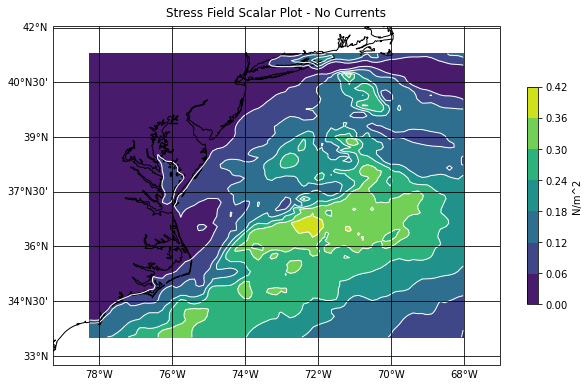

In [15]:
#2C stress field scalar plot
#Plot the field of stress as both a scalar field and a vector field. These can be on the same plot or separate plots. This will be turned in.
#plot magnitude? 

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, stressMag)
#contnour lines
ax.contour(Lon, Lat, stressMag, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Stress Field Scalar Plot - No Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


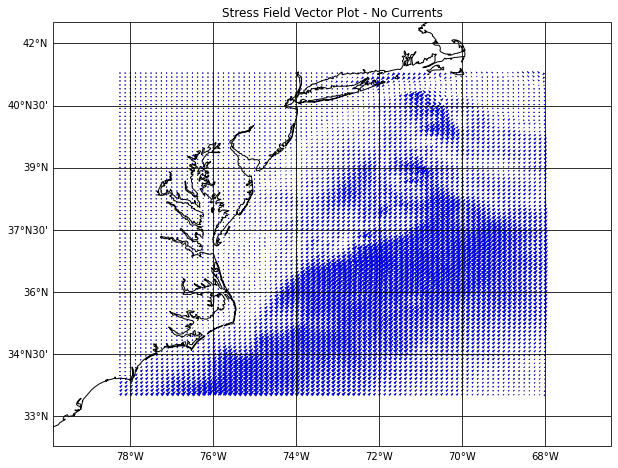

In [16]:
#2C stress field vector plot
#quiver([X, Y], U, V, [C], **kw)

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
#cs = ax.contourf(Lon, Lat, stressMag)
cs = ax.quiver(Lon, Lat, stressI, stressJ)
#contnour lines
#ax.contour(Lon, Lat, stressMag, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
ax.quiver(Lon, Lat, stressI, stressJ, color = 'blue', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Stress Field Vector Plot - No Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


In [17]:
#3A
#Calculate the stress for each grid point using the Smith 1988 model assuming that the stress is a function of the vertical wind shear. 
#To do this, the input wind speed is the magnitude of the vector difference of the wind and the current |U – Usfc|. 
#Save these stresses so you can use them in step 3B and 3C. 

withUcur=abs(uWind-uCurrent)
withVcur=abs(vWind-vCurrent)
withCmag=np.sqrt(withUcur**2+withVcur**2) 
#print(withMag)


In [18]:

from __future__ import print_function
from MFT21 import *
import sys

CONV_CRIT = 0.00005     #convergence critereon (fractional change)  []  
CONVECT = 0.0           #convective parameter  
warn = 0                #warning are given for 1, and hidden for 0    
eqv_neut_prm = 0        #output winds are winds rather than equivalent neutral winds  
z_wanted = 10.0         #height to which winds, potential temp, and humidity are adjusted                                
flux_model = 1         #BVW model=0  

Qnet = 5
sst_prm = 2 #wave age
z0_mom_prm = 0 #like the smith 88 model 
z0_TQ_prm = 1 #0, 1, 4, 5 are all ok 
stable_prm = 1
A_oil = 0.0

#Inputs I set 
dyn_in_prm = 0
dyn_in_val2 = 0.0
air_moist_prm = 0
ref_ht_wind = 10.0
ref_ht_tq = 2.0
sfc_moist_prm = 0
sfc_moist_val = 0.98 #over water 
salinity = 0.349 #global average
ss_prm = 0
ss_val = 28.0 #42.8 #typical of ocean/wind swell
astab = 1

#Outputs 
shf = 0.0
lhf = 0.0
tau = [0.0,0.0]
u_star = [0.0,0.0]
t_star = 0.0
q_star= 0.0
z_over_L = 0.0
wave_age = 0.0
dom_phase_spd = 0.0
hsig = 0.0
ww_stab = 0.0 
zo_m = 0.0001
u_at_z = 0.0
t_at_z = 0.0 
q_at_z = 0.0

#fill new arrays with zeros here 
#fills with float 
shfArrC=np.zeros((yLen,xLen))
lhfArrC=np.zeros((yLen,xLen))
tauArrC=np.zeros((yLen,xLen))
uStarArrC=np.zeros((yLen,xLen))
tStarArrC=np.zeros((yLen,xLen))
qStarArrC=np.zeros((yLen,xLen))
zOverlArrC=np.zeros((yLen,xLen))
waveAgeArrC=np.zeros((yLen,xLen))
domPhaseSpeedArrC=np.zeros((yLen,xLen))
hsigArrC=np.zeros((yLen,xLen))
wwStabArrC=np.zeros((yLen,xLen))
zomArrC=np.zeros((yLen,xLen))
uAtzArrC=np.zeros((yLen,xLen))
tAtzArrC=np.zeros((yLen,xLen))
qAtzArrC=np.zeros((yLen,xLen))

#fill each array with nans 
shfArrC[:]=np.nan
lhfArrC[:]=np.nan
tauArrC[:]=np.nan
uStarArrC[:]=np.nan
tStarArrC[:]=np.nan
qStarArrC[:]=np.nan
zOverlArrC[:]=np.nan
waveAgeArrC[:]=np.nan
domPhaseSpeedArrC[:]=np.nan
hsigArrC[:]=np.nan
wwStabArrC[:]=np.nan
zomArrC[:]=np.nan
uAtzArrC[:]=np.nan
tAtzArrC[:]=np.nan
qAtzArrC[:]=np.nan


#use i & j in future
for x in range(8,xLen-8):
    for y in range(8,yLen-8):
        
        #print('Test1', x, y, windMag[y,x])
        
        #assign other input arrays here
        dyn_in_val = withCmag[y,x]
        pressure = slpPa[y,x]
        air_moist_val = humid[y,x]
        t_air=airTC[y,x]
        t_skin=SSTC[y,x]
        
        if np.isnan(t_skin) == False:
        #if dyn_in_val>=0.0 and dyn_in_val<=100.0:
            #continue 
        #if dyn_in_val!=float("nan"):
        #print('Test2')
           
            try:

                count, shf, lhf, tau, u_star, t_star, q_star, z_over_L, wave_age, dom_phase_spd, hsig, ww_stab, zo_m, u_at_z, t_at_z, q_at_z = ht_adj_( dyn_in_prm, 
                        dyn_in_val, dyn_in_val2, CONVECT, CONV_CRIT,
                        pressure, air_moist_prm, air_moist_val, sfc_moist_prm, sfc_moist_val,
                        salinity, ss_prm, ss_val, t_air, sst_prm, t_skin, ref_ht_wind, ref_ht_tq,
                        z_wanted, astab, eqv_neut_prm, Qnet, warn, flux_model, z0_mom_prm, z0_TQ_prm, stable_prm,
                        A_oil, u_star, t_star, q_star, z_over_L, wave_age, dom_phase_spd, hsig, ww_stab, zo_m, u_at_z, t_at_z, q_at_z )

                #shf as output from function above
                #assign other array outputs here

                shfArrC[y,x]=shf
                lhfArrC[y,x]=lhf
                #take only first part of tau, the second dictionary element is always zero
                tauArrC[y,x]=tau[0]
                #dictionary
                uStarArrC[y,x]=u_star[0]
                tStarArrC[y,x]=t_star
                qStarArrC[y,x]=q_star
                zOverlArrC[y,x]=z_over_L
                waveAgeArrC[y,x]=wave_age
                domPhaseSpeedArrC[y,x]=dom_phase_spd
                hsigArrC[y,x]=hsig
                wwStabArrC[y,x]=ww_stab
                zomArrC[y,x]=zo_m
                uAtzArrC[y,x]=u_at_z
                tAtzArrC[y,x]=t_at_z
                qAtzArrC[y,x]=q_at_z
                
                #print(shf)

            except ZeroDivisionError:
                #print whatever type of error it is, and print the values associated with the error 
                print("Problem!")
                print(dyn_in_val)
                print(pressure)
                print(air_moist_val)
                print(t_air)
                print(t_skin)



In [19]:
#calculate stress vector when current=data
#u_star is m/s

#For the next step you will need a calculate a stress vector, by multiplying the stress magnitude by a unit vector of the wind shear:
#(tau_x, tau_y) = stress_magnitude * ( u – u_sfc, v – v_sfc) / | ( u – u_sfc, v – v_sfc) |

stressIcur=tauArrC*(uWind-uCurrent)/abs(uWind-uCurrent)
stressJcur=tauArrC*(vWind-vCurrent)/abs(vWind-vCurrent)
stressMagcur=np.sqrt(stressI**2+stressJ**2) 
#print(stressIcur.shape)
#print(stressJcur.shape)
#print(stressMagcur.shape)

In [20]:
#3B - metPy version
#Calculate the curl of the stress (from 3A) and plot this (possibly after outputting and using a different language to plot). 
#Calculate the curl with the same method that you used in 2B. Turn in the plot of the curl of the stress. 

#Vorticity=curl
#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
dxdy=mpcalc.lat_lon_grid_deltas(longitude=Lon, latitude=Lat, x_dim=- 1, y_dim=- 2, geod=None)
#print(dxdy)#in meters

#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
curlCur=mpcalc.vorticity(u=stressIcur*units('m/s'), v=stressJcur*units('m/s'), dx=dxdy[0], dy=dxdy[1])
#print(curlNoCurrent)
    

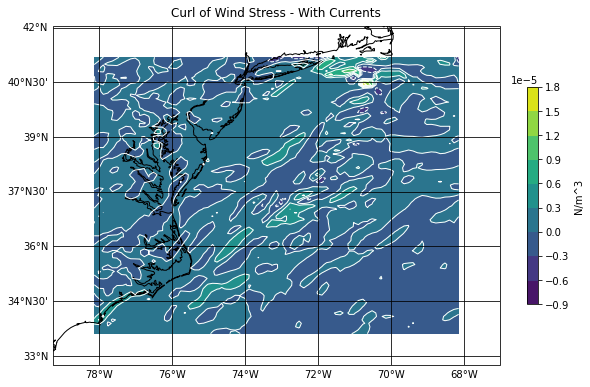

In [21]:
#3B PLOT - metPy version
mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, curlCur)
#contnour lines
ax.contour(Lon, Lat, curlCur, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Curl of Wind Stress - With Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()

In [19]:
#3B - hard code version 

#get dy & dx
#deg2Meter=111100
#new_dx=np.zeros((98,98))
#new_dy=np.zeros((98,98))
#for y in range(len(Lat)-1):
#    new_dy[:,y]=(Lat[y+1]-Lat[y])*deg2Meter
#for y in range(len(Lat)-1):
#    latAdjust=np.cos(np.pi*Lat[y]/180)
#    for x in range(len(Lon)-1):
#        new_dx[y,x]=(Lon[x+1]-Lon[x])*deg2Meter*latAdjust

#print(new_dx.shape)
#print(new_dy.shape)

#dudy=np.zeros((97,97))
#dvdx=np.zeros((97,97))

#get vorticity/curl 
#for y in range(1,len(Lat)-2):
#    for x in range(1,len(Lon)-2):
        #Winds
        #dudyN=(uWind[y-1,x]-uWind[y,x])/((Lat[y-1]-Lat[y])*deg2Meter)
        #dudyS=(uWind[y,x])-uWind[y+1,x]/((Lat[y]-Lat[y+1])*deg2Meter)
        #dvdxE=(vWind[y,x+1]-vWind[y,x])/((Lon[x+1]-Lon[x])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
        #dvdxW=(vWind[y,x-1]-vWind[y,x])/((Lon[x]-Lon[x-1])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
        
        #Wind Stress
#        dudyN=(stressIcur[y-1,x]-stressIcur[y,x])/((Lat[y-1]-Lat[y])*deg2Meter)
#        dudyS=(stressIcur[y,x])-stressIcur[y+1,x]/((Lat[y]-Lat[y+1])*deg2Meter)
#        dvdxE=(stressJcur[y,x+1]-stressJcur[y,x])/((Lon[x+1]-Lon[x])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
#        dvdxW=(stressJcur[y,x-1]-stressJcur[y,x])/((Lon[x]-Lon[x-1])*np.cos(np.pi*Lat[y]/180)*deg2Meter)
        
        
#       dudy[y,x]=(dudyN+dudyS)/2
#        dvdx[y,x]=(dvdxE+dvdxW)/2

#curlC=dvdx-dudy

#print(curl.shape)
#print(curl)


In [20]:
#3B Plot- hard code version 

#mapcrs = ccrs.PlateCarree()
#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
#ax.coastlines()
#filled contours (lon, lat, thing plotted)
#cs = ax.contourf(Lon[1:98], Lat[1:98], curlC, transform=mapcrs)
#contnour lines
#ax.contour(Lon[1:98], Lat[1:98], curlC, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
#PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, label = '1/s')
#gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
#gl.top_labels = False
#gl.ylabels_right = False
#plt.title('Curl of Wind Stress - No Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
#plt.show()


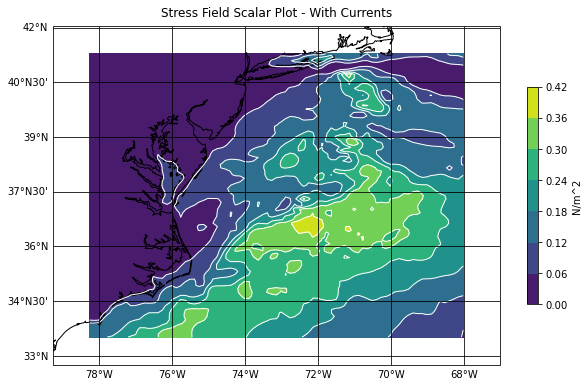

In [22]:
#3C stress vector as scalar plot 
#Plot the field of the stress determined in 3A as both a scalar field and a vector field. 

#plot magnitude? 

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, stressMagcur)
#contnour lines
ax.contour(Lon, Lat, stressMagcur, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Stress Field Scalar Plot - With Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


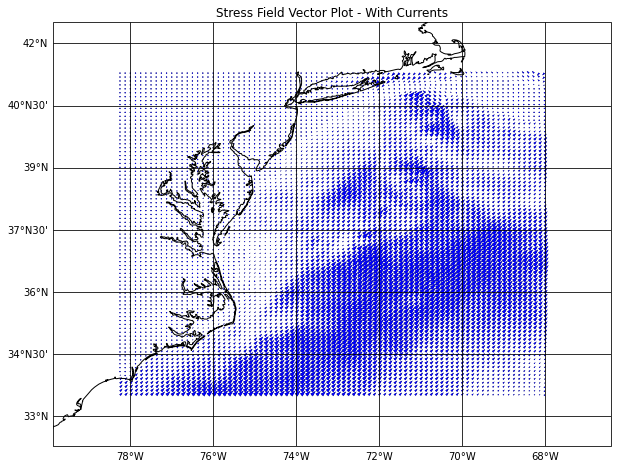

In [23]:
#3C stress vector as vector field plot 

#quiver([X, Y], U, V, [C], **kw)

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
#cs = ax.contourf(Lon, Lat, stressMag)
cs = ax.quiver(Lon, Lat, stressIcur, stressJcur)
#contnour lines
#ax.contour(Lon, Lat, stressMag, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
ax.quiver(Lon, Lat, stressIcur, stressJcur, color = 'blue', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Stress Field Vector Plot - With Currents')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


In [25]:
#4
# Plot the differences of these fields of curl of stress: The case without currents minus the case with currents. 
#The result would be the error due to ignoring currents. Turn this in. 

#Curl of stress without currents
dxdy=mpcalc.lat_lon_grid_deltas(longitude=Lon, latitude=Lat, x_dim=- 1, y_dim=- 2, geod=None)
curlNoCurrent=mpcalc.vorticity(u=stressI*units('m/s'), v=stressJ*units('m/s'), dx=dxdy[0], dy=dxdy[1])

#curl of stress with currents 
curlCur=mpcalc.vorticity(u=stressIcur*units('m/s'), v=stressJcur*units('m/s'), dx=dxdy[0], dy=dxdy[1])

noCurError=curlNoCurrent-curlCur

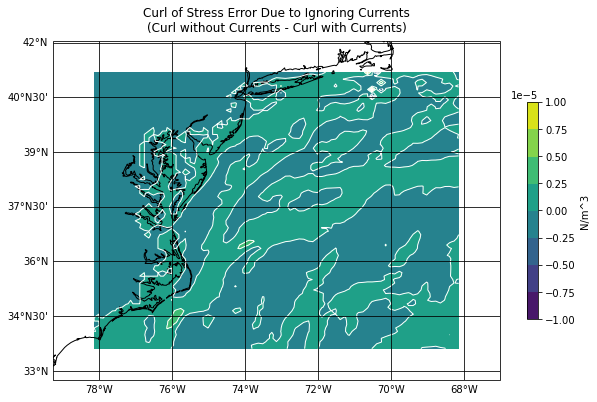

In [26]:
#4 Error plot (curl of stress with currents - curl of wing without currents )

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, noCurError)
#contnour lines
ax.contour(Lon, Lat, noCurError, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^3')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Curl of Stress Error Due to Ignoring Currents\n(Curl without Currents - Curl with Currents)')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


In [25]:
#5
#Calculate the error in Ekman mass transport due to ignoring currents.
#+/ccw wind stress curl = ocean div = upwell
#-/cw wind stress curl = ocean conv = downwell 
#f=mpcalc.coriolis_parameter(Lat)
omega=7.2921**-5
f=2*omega*np.sin(Lat*3.141592/180)
#print(f)
#ekTransErr=noCurError*(1/f)

#OR in N/m^2s
#My=-taux/f
#Mx=tauy/f

Taux=stressI-stressIcur
Tauy=stressJ-stressJcur
#print(stressI)
#print(stressIcur)
#print(Taux)

My=-Taux/f
Mx=Tauy/f
errMag=np.sqrt(My**2+Mx**2)
#withCmag=np.sqrt(withUcur**2+withVcur**2) 

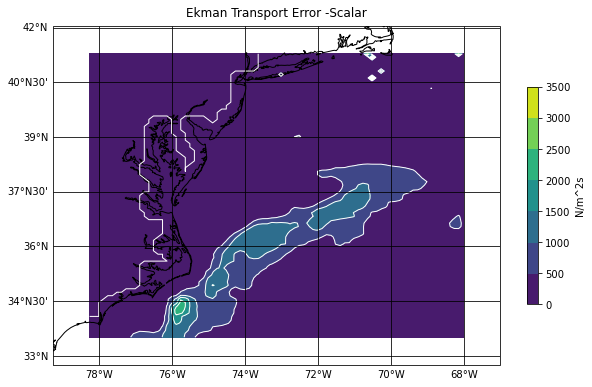

In [26]:
#5 Error in Ekman mass transport plot - Mx & My SCALAR

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, errMag)
#contnour lines
ax.contour(Lon, Lat, errMag, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^2s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Ekman Transport Error -Scalar')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()

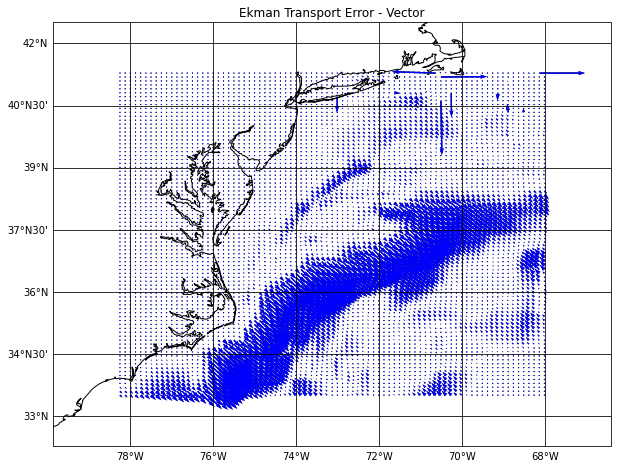

In [31]:
#5 Error in Ekman mass transport plot - Mx & My VECTOR

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
#cs = ax.contourf(Lon, Lat, stressMag)
cs = ax.quiver(Lon, Lat, Mx, My)
#contnour lines
#ax.contour(Lon, Lat, stressMag, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
ax.quiver(Lon, Lat, Mx, My, color = 'blue', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
#plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'N/m^2')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Ekman Transport Error - Vector')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()


In [28]:
#5
#Calculate the error in Ekman upwelling due to ignoring currents. Turn in both plots
#+/ccw wind stress curl = ocean div = upwell

#vert velocity @ bottom of layer=(1/roh*f)(gradient curl tau)
dxdy=mpcalc.lat_lon_grid_deltas(longitude=Lon, latitude=Lat, x_dim=- 1, y_dim=- 2, geod=None)

omega=7.2921**-5
f=2*omega*np.sin(Lat*3.141592/180)
#density of salt water? 1.02g/cm^3 to kg/m^3
roh=1.02*1000 
Taux=stressI-stressIcur
Tauy=stressJ-stressJcur
#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
ekmanUpError=(1/roh*f)*mpcalc.vorticity(Taux*units('m/s'), Tauy*units('m/s'), dx=dxdy[0], dy=dxdy[1])


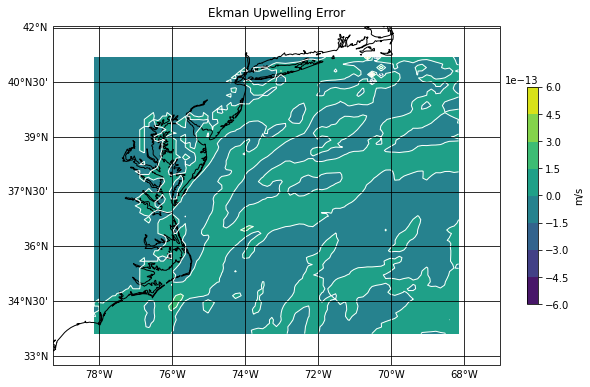

In [32]:
#Plot scalar error in Ekman upwelling as metPy

mapcrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#gives coastlines
ax.coastlines()
#filled contours (lon, lat, thing plotted)
cs = ax.contourf(Lon, Lat, ekmanUpError)
#contnour lines
ax.contour(Lon, Lat, ekmanUpError, colors = 'white', linewidths = 1, transform=ccrs.PlateCarree())
#ax=plt.gca()
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
#don't want labels
gl.top_labels = False
gl.ylabels_right = False
plt.title('Ekman Upwelling Error')
#plt.savefig('PV_110.png', bbox_inches='tight', dpi=150)
plt.show()

In [30]:
#5 Error in Ekman upwelling plot
